# Figure 7: Contrast Grid

This code is used to create **Figure 7** in the **Apples with Apples** paper [(Bonse et al. 2023)](../../05_citation.rst). The code presents the contrast gird and how it is related to the residuals of fake planet.

**For more information on how to calculate contrast grids with applefy click** [here](../../02_user_documentation/02_contrast_grid.ipynb).

## Imports

In [1]:
from pathlib import Path

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

from applefy.detections.contrast import Contrast
from applefy.detections.uncertainty import compute_detection_uncertainty

from applefy.utils.photometry import AperturePhotometryMode
from applefy.statistics import TTest, gaussian_sigma_2_fpf, \
    fpf_2_gaussian_sigma

from applefy.utils.file_handling import load_adi_data, read_apples_with_apples_root
from applefy.utils.positions import center_subpixel, estimate_reference_positions
from applefy.utils import flux_ratio2mag, mag2flux_ratio

## Data Loading

Figure 7 runs several fake planet experiments on the unstacked NACO data (see details in the paper). In order to run the code **make sure to download the data from Zenodo and [read the instructions](../02_paper_data.md) on how to setup the files**.

In [2]:
experiment_root = read_apples_with_apples_root()

Data in the APPLES_ROOT_DIR found. Location: /home/ipa/quanz/user_accounts/mbonse/2021_Metrics/70_results/apples_root_dir


The HR (High Temporal Resolution) data is the unstacked NACO data. Calculations with this data can be **computationally intensive**. You can also run the code with the LR (Low Temporal Resolution) data to save time.

In [3]:
# 30_data/betapic_naco_lp_LR
dataset_file = experiment_root / Path("30_data/betapic_naco_lp_HR.hdf5")
science_data_key = "science_no_planet"
psf_template_key = "psf_template"
parang_key = "header_science_no_planet/PARANG"

dit_psf_template = 0.02019
dit_science = 0.2
fwhm = 4.2  # estimeated with Pynpoint in advance

We load the unstacked NACO data. In order to save computation time we reduce the resolution of the science sequence by cutting around the central star.

In [4]:
# we need the psf template for contrast calculation
science_data, angles, raw_psf_template_data = load_adi_data(
    dataset_file,
    data_tag=science_data_key,
    psf_template_tag=psf_template_key,
    para_tag=parang_key)

psf_template = raw_psf_template_data[82:-82, 82:-82]
science_data = science_data[:, 55:-55, 55:-55]

## Compute the Contrast Grid

We use the class [Contrast](../../03_package/detections.rst#applefy.detections.contrast.Contrast) of applefy to calculate the contrast grid.

In [5]:
checkpoint_dir = experiment_root / Path("70_results/detection_limits/contrast_grid_hr")

contrast_instance = Contrast(
    science_sequence=science_data,
    psf_template=psf_template,
    parang_rad=angles,
    psf_fwhm_radius=fwhm / 2,
    dit_psf_template=dit_psf_template,
    dit_science=dit_science,
    checkpoint_dir=checkpoint_dir)

### Step 1: Design fake planet experiments

In the first step we **choose** at which **separations** and for which **planet brightness** we want to insert fake planets. Compared to the example shown in the [user documentation](../../02_user_documentation/02_contrast_grid.ipynb) we run much more fake planet experiments in order to **increase the resolution** of the contrast grid. This is computational expensive on the unstacked data!

In [6]:
# fake planet brightness
flux_ratios_mag = np.linspace(5, 15, 21)
flux_ratios = mag2flux_ratio(flux_ratios_mag)

print("Brightness of fake planets in mag: " + str(flux_ratios_mag))
print("Planet-to-star flux ratio: " + str(flux_ratios))

Brightness of fake planets in mag: [ 5.   5.5  6.   6.5  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5
 12.  12.5 13.  13.5 14.  14.5 15. ]
Planet-to-star flux ratio: [1.00000000e-02 6.30957344e-03 3.98107171e-03 2.51188643e-03
 1.58489319e-03 1.00000000e-03 6.30957344e-04 3.98107171e-04
 2.51188643e-04 1.58489319e-04 1.00000000e-04 6.30957344e-05
 3.98107171e-05 2.51188643e-05 1.58489319e-05 1.00000000e-05
 6.30957344e-06 3.98107171e-06 2.51188643e-06 1.58489319e-06
 1.00000000e-06]


By default, separations are selected in steps of 1 FWHM from the central star to the edge of the image. **We want twice the resolution for this plot**. The separations have to be given in pixel values.

In [7]:
# We want the double resolution as in the tutorial example
center = center_subpixel(science_data[0])
separations = np.arange(2.1, center[0], fwhm/2)[1:]
separations

array([ 4.2,  6.3,  8.4, 10.5, 12.6, 14.7, 16.8, 18.9, 21. , 23.1, 25.2,
       27.3, 29.4, 31.5, 33.6, 35.7])

For each cell in the contrast grid we calculate *num_fake_planets* (between min=1 and max=6) planet residuals.

In [8]:
num_fake_planets = 6

contrast_instance.design_fake_planet_experiments(
    flux_ratios=flux_ratios,
    num_planets=num_fake_planets,
    separations=separations,
    overwrite=True)

Overwriting existing config files.


### Step 2: Run fake planet experiments

In the second step we **insert fake planetes** as chosen in the first step. For each planet we **run a full-frame PCA** to obtain a residual image. We use the [PynPoint](https://pynpoint.readthedocs.io/en/latest/) [wrappers](../../03_package/wrappers.rst) of applefy.

In [9]:
from applefy.wrappers.pynpoint import MultiComponentPCAPynPoint

We compute the results for 5, 10, 20, 30 and 50 PCA components. For the plot later only one of the results is used.

In [10]:
components = [5, 10, 20, 30, 50]

**Make sure to choose a scratch folder which has a high bandwidth!**

In [11]:
algorithm_function = MultiComponentPCAPynPoint(
    num_pcas=components,
    scratch_dir=Path("/scratch/mbonse/applefy_scratch/"),
    num_cpus_pynpoint=1)

If the results are available from previous calculations the following step will just restore the residuals.

In [12]:
contrast_instance.run_fake_planet_experiments(
    algorithm_function=algorithm_function,
    num_parallel=32)

Running fake planet experiments...

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2017/2017 [00:12<00:00, 155.76it/s]


[DONE]


### Step 3: Compute the contrast grid

Since we are close to the star in the speckle dominated regime we use spaced pixel instead of apertures to measure the pixel and noise photometry.

In [13]:
photometry_mode_planet = AperturePhotometryMode("FS", search_area=0.5)
photometry_mode_noise = AperturePhotometryMode("P")

In [14]:
contrast_instance.prepare_contrast_results(
    photometry_mode_planet=photometry_mode_planet,
    photometry_mode_noise=photometry_mode_noise)

Next, we calculate the contrast grid using a [t-test](../../03_package/statistics.rst#applefy.statistics.parametric.TTest).

In [15]:
statistical_test = TTest()

In [16]:
_, contrast_grids = contrast_instance.compute_contrast_grids(
    statistical_test=statistical_test,
    num_cores=32,
    confidence_level_fpf=gaussian_sigma_2_fpf(5),
    num_rot_iter=32,
    safety_margin=1.0,
    pixel_scale=0.02718)

Computing contrast grid for PCA (005 components)
Computing contrast grid with multiprocessing:
................................................................................................................................................................................................................................................................................................................................................[DONE]
Computing contrast grid for PCA (010 components)
Computing contrast grid with multiprocessing:
................................................................................................................................................................................................................................................................................................................................................[DONE]
Computing contrast grid for PCA (020 components)
Computing contrast grid with multiprocessing:
.............................

Extract one contrast grid for the plot.

In [17]:
contrast_grid = contrast_grids['PCA (030 components)']
contrast_result = contrast_instance.contrast_results['PCA (030 components)']

## Collect Residuals and fake planet positions

Each value in a contrast grid is based on several (here 6) fake planet residuals. In the plot we give 3 example residuals for two different values in the grid. 

First we select two positions in the grid.

In [18]:
# change this to pic different (separation, fulx_ratio)
tmp_idx1 = contrast_result.idx_table.iloc[2, 7]
tmp_idx2 = contrast_result.idx_table.iloc[8, 10]

# Some print messages
separation1 = contrast_result.idx_table.index[2] / fwhm
separation2 = contrast_result.idx_table.index[8] / fwhm
contrast1 = flux_ratio2mag(contrast_result.idx_table.columns[7])
contrast2 = flux_ratio2mag(contrast_result.idx_table.columns[10])

print("The first value marked in the grid is: ")
print("separation " + str(separation1))
print("contrast " + str(contrast1))

print("The second value marked in the grid is: ")
print("separation " + str(round(separation2)))
print("contrast " + str(contrast2))

The first value marked in the grid is: 
separation 2.0
contrast 8.5
The second value marked in the grid is: 
separation 5
contrast 10.0


Next we need to get the corresponding residuals and positions of the fake planets injected by applefy.

In [19]:
tmp_tp_residuals1 = [i[0] for i in contrast_result.planet_dict[tmp_idx1][::2]]
tmp_planet_positions1 = [i[1] for i in contrast_result.planet_dict[tmp_idx1][::2]]

tmp_tp_residuals2 = [i[0] for i in contrast_result.planet_dict[tmp_idx2][::2]]
tmp_planet_positions2 = [i[1] for i in contrast_result.planet_dict[tmp_idx2][::2]]

A small helper function to esimate the noise positions for all planet positions.

In [20]:
def get_reference_positions(planet_positions):
    tmp_ref_positions = []
    for tmp_planet_pos in planet_positions:
        tmp_noise_positions  = estimate_reference_positions(
            planet_position = tmp_planet_pos[:2],
            center=center,
            psf_fwhm_radius=fwhm/2,
            angle_offset=0,
            safety_margin=1.0)

        tmp_ref_positions.append(tmp_noise_positions)
        
    return tmp_ref_positions

Find the reference positions.

In [21]:
tmp_ref_positions1 = get_reference_positions(tmp_planet_positions1)
tmp_ref_positions2 = get_reference_positions(tmp_planet_positions2)

## Create the Plot

Define the colors we use.

In [22]:
color_palette = [sns.color_palette("colorblind")[1],
                 sns.color_palette("colorblind")[8]]

Convert some units of the contrast grid.

In [23]:
contrast_grid_sigma = contrast_grid.applymap(fpf_2_gaussian_sigma)
contrast_grid_sigma.index = flux_ratio2mag(contrast_grid_sigma.index)
contrast_grid_sigma.columns = np.round(contrast_grid_sigma.columns.values, 2)

A small helper function to plot residual images. The function marks the position of the injected fake planets as well as example positions at which the noise is extracted.

In [ ]:
def plot_example_residuals(ref_positions,
                           planet_positions,
                           tp_residuals,
                           axes_in,
                           frame_color):
    
    v_min = np.min(np.array(tp_residuals))
    v_max = np.max(np.array(tp_residuals))

    for i in range(len(tp_residuals)):
        axes_in[i].imshow(tp_residuals[i], vmin=v_min, vmax=v_max)
        
        axes_in[i].scatter(
            np.array(ref_positions[i])[:,0], 
            np.array(ref_positions[i])[:,1], 
            alpha=0.8,
            marker="x", color='white', lw=5, s=2)
        
        axes_in[i].scatter(
            np.array(planet_positions)[i,0], 
            np.array(planet_positions)[i,1], 
            alpha=0.8,
            marker="o", facecolors='none', 
            edgecolors='red', s=100, lw=1.5)
        
        axes_in[i].axes.get_yaxis().set_ticks([])
        axes_in[i].axes.get_xaxis().set_ticks([])
        plt.setp(axes_in[i].spines.values(), color=frame_color)
        plt.setp(axes_in[i].spines.values(), lw=3)
        
        # Compute the detection confidence and add the text
        tmp_median_p, p_values, t_values = compute_detection_uncertainty(
            tp_residuals[i],
            np.array(planet_positions)[i],
            statistical_test=TTest(),
            psf_fwhm_radius=2.1,
            photometry_mode_planet=photometry_mode_planet,
            photometry_mode_noise=photometry_mode_noise,
            num_rot_iter=50,
            safety_margin=1.0)

        p_value = fpf_2_gaussian_sigma(tmp_median_p)
        
        axes_in[i].text(
            0.08, 0.08, r"$FPF_{{median}} = {:10.1f} "
            "\sigma_{{\mathcal{{N}}}}$".format(p_value),
            color="white", ha="left", fontsize=14, 
            transform = axes_in[i].transAxes)

A small helper function to plot the contrast grid.

In [25]:
def plot_contrast_grid(
    axis_in,
    tmp_contrast_results,
    colorbar_ax_in):
    
    c_bar_kargs = dict(orientation = "vertical",
                       label = r"FPF [$\sigma_{\mathcal{N}}$]")
    
    heat = sns.heatmap(tmp_contrast_results,
                       vmax=2, vmin=7, 
                       annot=True,
                       cmap="YlGnBu",
                       ax=axis_in,
                       cbar_ax=colorbar_ax_in,
                       cbar_kws=c_bar_kargs)
    
    ylabels = ['{:.1f}'.format(float(x.get_text()))
               for x in heat.get_yticklabels()]
    _=heat.set_yticklabels(ylabels)

Create the final figure.

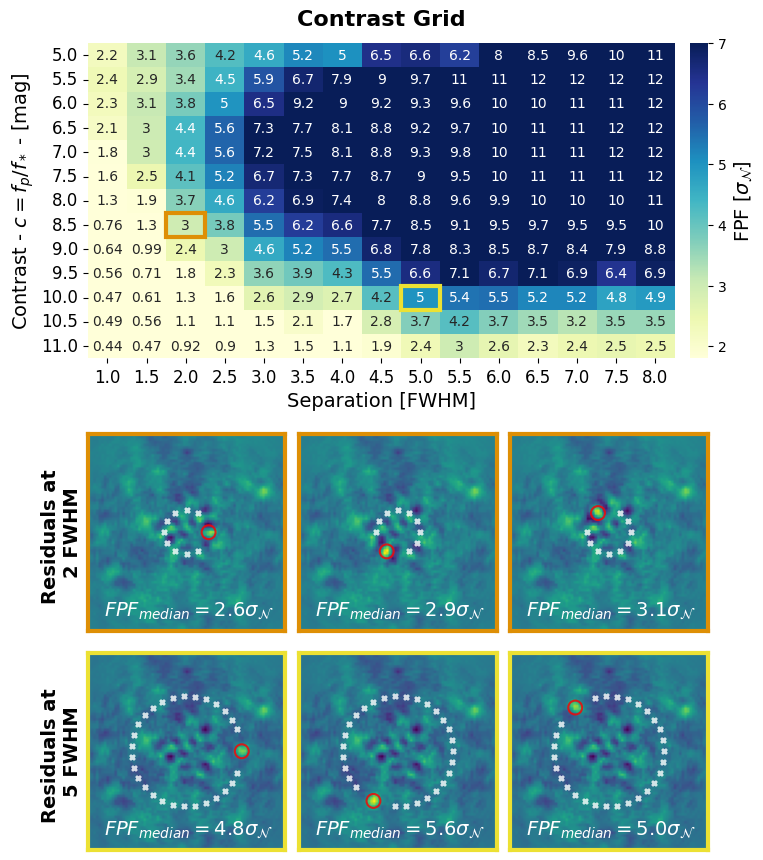

In [26]:
# 1. Create the Plot Layout -------------------------------------
fig = plt.figure(
    constrained_layout=False, 
    figsize=(8, 10.5))

gs0 = fig.add_gridspec(2, 1, height_ratios=[1.5, 2])
gs0.update(wspace=0.0, hspace=0.2)
gs1 = gridspec.GridSpecFromSubplotSpec(
    1, 2, subplot_spec = gs0[0], 
    wspace=0.05, width_ratios=[1, 0.03])

gs2 = gridspec.GridSpecFromSubplotSpec(
    2, 3, subplot_spec = gs0[1], 
    wspace=0.07, hspace=0.09, width_ratios=[1, 1, 1])

# All axis we need
contrast_ax = fig.add_subplot(gs1[0])
colorbar_ax = fig.add_subplot(gs1[1])

ax_residual_1_1 =  fig.add_subplot(gs2[0, 0])
ax_residual_1_2 =  fig.add_subplot(gs2[0, 1])
ax_residual_1_3 =  fig.add_subplot(gs2[0, 2])
ax_residual_2_1 =  fig.add_subplot(gs2[1, 0])
ax_residual_2_2 =  fig.add_subplot(gs2[1, 1])
ax_residual_2_3 =  fig.add_subplot(gs2[1, 2])


# 2. Plot the contrast grid --------------------------------------
plot_contrast_grid(
    contrast_ax, 
    contrast_grid_sigma[:11].iloc(axis=1)[:-1],
    colorbar_ax)

colorbar_ax.yaxis.label.set_size(14)

contrast_ax.set_ylabel(
    "Contrast - $c = f_p / f_*$ - [mag]", size=14)
contrast_ax.set_xlabel(
    r"Separation [FWHM]", size=14)
contrast_ax.set_title(
    "Contrast Grid", 
    fontsize=16, fontweight="bold", y=1.03)

# 3. Make squares to mark the position of the selected residuals --
rect = patches.Rectangle(
    ((separation1-1)*2, contrast1 - 1.5), 1, 1,
    linewidth=3, edgecolor=color_palette[0], facecolor='none')

contrast_ax.add_patch(rect)
rect = patches.Rectangle(
    ((separation2-1)*2, contrast2), 1, 1,
    linewidth=3, edgecolor=color_palette[1], facecolor='none')

contrast_ax.add_patch(rect)
contrast_ax.tick_params(axis='both', which='major', labelsize=12)

# 4. Plot the residuals -------------------------------------------
plot_example_residuals(
    tmp_ref_positions1,
    tmp_planet_positions1, 
    tmp_tp_residuals1,
    [ax_residual_1_1, ax_residual_1_2, ax_residual_1_3],
    color_palette[0])

plot_example_residuals(
    tmp_ref_positions2,
    tmp_planet_positions2, 
    tmp_tp_residuals2,
    [ax_residual_2_1, ax_residual_2_2, ax_residual_2_3], 
    color_palette[1])

ax_residual_1_1.set_ylabel(
    "Residuals at \n" + r"2 FWHM", size=14, fontweight="bold")
ax_residual_2_1.set_ylabel(
    "Residuals at \n" + r"5 FWHM", size=14, fontweight="bold")

# 5. Save the figure ----------------------------------------------
fig.patch.set_facecolor('white')
plt.savefig("./07_contrast_grid.pdf", bbox_inches='tight')